# Importing Necessary Packages

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Preprocessing and encoding
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders.count import CountEncoder

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Dimensionality reduction
from sklearn.decomposition import PCA

# Feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Model
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor


# Data Loading

In [2]:
train_data = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv', parse_dates=['date'])
test_data = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv', parse_dates=['date'])

In [3]:
# Count of zero and non-zero purchase values
zero_purchases = (train_data['purchaseValue'] == 0).sum()
non_zero_purchases = (train_data['purchaseValue'] != 0).sum()

print(f"🛒 Zero purchase entries      : {zero_purchases}")
print(f"💰 Non-zero purchase entries : {non_zero_purchases}")


🛒 Zero purchase entries      : 92038
💰 Non-zero purchase entries : 23985


In [4]:
# Show all rows in DataFrame outputs
pd.set_option('display.max_rows', None)

# Show all columns in DataFrame outputs
pd.set_option('display.max_columns', None)

# Data Exploration

In [5]:
# Displaying the first 5 rows of the training dataset:
train_data.head()


,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,device.mobileInputSelector,userId,trafficSource.campaign,device.mobileDeviceMarketingName,geoNetwork.networkDomain,gclIdPresent,device.operatingSystemVersion,sessionNumber,device.flashVersion,geoNetwork.region,trafficSource,totals.visits,geoNetwork.networkLocation,sessionId,os,geoNetwork.subContinent,trafficSource.medium,trafficSource.adwordsClickInfo.isVideoAd,browserMajor,locationCountry,device.browserSize,trafficSource.adwordsClickInfo.adNetworkType,socialEngagementType,geoNetwork.city,trafficSource.adwordsClickInfo.page,geoNetwork.metro,pageViews,locationZone,device.mobileDeviceModel,trafficSource.referralPath,totals.bounces,date,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,not available in demo dataset,61421,(not set),not available in demo dataset,domain1,0,not available in demo dataset,1,not available in demo dataset,Washington,youtube.com,1,not available in demo dataset,1500100799,Windows,Northern America,referral,NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,Redmond,NaN,Seattle-Tacoma WA,1.0,8,not available in demo dataset,/intl/hr/yt/about/,1.0,2017-07-14,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,not available in demo dataset,72287,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,California,(direct),1,not available in demo dataset,1495262065,Macintosh,Northern America,(none),NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,Mountain View,NaN,San Francisco-Oakland-San Jose CA,1.0,8,not available in demo dataset,NaN,1.0,2017-05-19,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,not available in demo dataset,25180,(not set),not available in demo dataset,domain1,0,not available in demo dataset,2,not available in demo dataset,Lombardy,google,1,not available in demo dataset,1508510328,Windows,Southern Europe,organic,NaN,not available in demo dataset,Italy,not available in demo dataset,NaN,Not Socially Engaged,Milan,NaN,(not set),6.0,8,not available in demo dataset,NaN,NaN,2017-10-20,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,not available in demo dataset,41295,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,not available in demo dataset,youtube.com,1,not available in demo dataset,1483431838,Windows,Eastern Asia,referral,NaN,not available in demo dataset,Japan,not available in demo dataset,NaN,Not Socially Engaged,not available in demo dataset,NaN,not available in demo dataset,1.0,8,not available in demo dataset,/yt/about/ja/,1.0,2017-01-03,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,not available in demo dataset,113697,(not set),not available in demo dataset,domain1,0,not av

In [6]:
print(f"\033[1mShape of the training data is:\033[0m {train_data.shape}")

Shape of the training data is: (116023, 52)


In [7]:
# Examine data types
print("\033[1mData Types:\033[0m")
print(train_data.info())

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   trafficSource.isTrueDirect                    42890 non-null   object        
 1   purchaseValue                                 116023 non-null  float64       
 2   browser                                       116023 non-null  object        
 3   device.screenResolution                       116023 non-null  object        
 4   trafficSource.adContent                       2963 non-null    object        
 5   trafficSource.keyword                         44162 non-null   object        
 6   screenSize                                    116023 non-null  object        
 7   geoCluster                                    116023 non-null  object        
 8   trafficSource.adwordsClickInfo.slot       

In [8]:
def analyze_object_columns(df):
    """
     Analyze all object/string columns in the given DataFrame.

    For each column:
    - Prints the column name
    - Shows number of missing (NaN) values
    - Displays the count of unique values
    - Lists the first 10 unique values (if more, adds ellipsis)
    """

    # Select all columns with data type 'object' or 'string'
    obj_cols = df.select_dtypes(include=['object', 'string'])

    # Loop through each object/string column
    for col in obj_cols.columns:
        print(f"\n---  Column: {col} ---")

        # Print number of missing values
        print(f" Missing values      : {df[col].isna().sum()}")

        # Print number of unique values
        print(f" Unique values count: {df[col].nunique()}")

        # Print first 10 unique values
        unique_vals = df[col].dropna().unique()
        preview = unique_vals[:10]
        suffix = ' ...' if len(unique_vals) > 10 else ''
        print(f" Sample unique values: {preview}{suffix}")

analyze_object_columns(train_data)


---  Column: trafficSource.isTrueDirect ---
 Missing values      : 73133
 Unique values count: 1
 Sample unique values: [True]

---  Column: browser ---
 Missing values      : 0
 Unique values count: 34
 Sample unique values: ['Edge' 'Chrome' 'Internet Explorer' 'Safari' 'Android Webview' 'Firefox'
 'Opera' 'Opera Mini' 'UC Browser' 'Nintendo Browser'] ...

---  Column: device.screenResolution ---
 Missing values      : 0
 Unique values count: 1
 Sample unique values: ['not available in demo dataset']

---  Column: trafficSource.adContent ---
 Missing values      : 113060
 Unique values count: 53
 Sample unique values: ['Google Merchandise Collection' 'Google Merchandise Store' 'Bags 336x280'
 'Display Ad created 3/11/14' 'Ad from 12/13/16' 'Swag with Google Logos'
 'Placement Accessores 300 x 250' 'Display Ad created 3/11/15'
 'Smart display ad - 8/17/2017' 'Google Online Store'] ...

---  Column: trafficSource.keyword ---
 Missing values      : 71861
 Unique values count: 566
 Sampl

In [9]:
def analyze_number_columns(df):
    """
     Analyze all numerical columns in the given DataFrame.

    For each column:
    - Prints the column name
    - Shows number of missing (NaN) values
    - Displays the count of unique values
    - Lists the first 10 unique values (adds ellipsis if more)
    """

    # Select all columns with numeric data types (int, float)
    num_cols = df.select_dtypes(include=['number'])

    # Loop through each numeric column
    for col in num_cols.columns:
        print(f"\n---  Column: {col} ---")

        # Print number of missing values
        print(f" Missing values      : {df[col].isna().sum()}")

        # Print number of unique values
        print(f" Unique values count: {df[col].nunique()}")

        # Print first 10 unique values
        unique_vals = df[col].dropna().unique()
        preview = unique_vals[:10]
        suffix = ' ...' if len(unique_vals) > 10 else ''
        print(f" Sample unique values: {preview}{suffix}")

analyze_number_columns(train_data)



---  Column: purchaseValue ---
 Missing values      : 0
 Unique values count: 6766
 Sample unique values: [       0. 88950000. 28000000. 80510000.  6000000. 31140000. 27180000.
 79990000. 69390000. 39980000.] ...

---  Column: userId ---
 Missing values      : 0
 Unique values count: 100499
 Sample unique values: [ 61421  72287  25180  41295 113697  36442  62247  39682  55604  55519] ...

---  Column: gclIdPresent ---
 Missing values      : 0
 Unique values count: 2
 Sample unique values: [0 1]

---  Column: sessionNumber ---
 Missing values      : 0
 Unique values count: 230
 Sample unique values: [  1   2   4   3   6 216   5   7 259  10] ...

---  Column: totals.visits ---
 Missing values      : 0
 Unique values count: 1
 Sample unique values: [1]

---  Column: sessionId ---
 Missing values      : 0
 Unique values count: 107379
 Sample unique values: [1500100799 1495262065 1508510328 1483431838 1475804633 1505506252
 1472053897 1490756441 1495702257 1500868868] ...

---  Column: tra

In [10]:
# ==============================
#  Missing Value Analysis
# ==============================

# Calculate total missing values per column
missing_values = train_data.isnull().sum()

# Calculate percentage of missing values
missing_percentage = (missing_values / train_data.shape[0]) * 100

# Display only columns with missing values
print("\n\033[1m Missing Values (% per column > 0):\033[0m")
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))



 Missing Values (% per column > 0):
trafficSource.adContent                         97.446196
trafficSource.adwordsClickInfo.slot             96.310214
trafficSource.adwordsClickInfo.isVideoAd        96.310214
trafficSource.adwordsClickInfo.adNetworkType    96.310214
trafficSource.adwordsClickInfo.page             96.310214
trafficSource.referralPath                      63.184886
trafficSource.isTrueDirect                      63.033192
trafficSource.keyword                           61.936857
totals.bounces                                  59.363230
new_visits                                      30.601691
pageViews                                        0.006895
dtype: float64


In [11]:
# ==============================
#  Unique Value Count per Column
# ==============================

print("\n\033[1m Unique Value Counts (Descending):\033[0m")
unique_counts = train_data.nunique().sort_values(ascending=False)
print(unique_counts)



 Unique Value Counts (Descending):
sessionStart                                    107388
sessionId                                       107379
userId                                          100499
purchaseValue                                     6766
trafficSource.referralPath                         941
geoNetwork.city                                    695
date                                               638
trafficSource.keyword                              566
geoNetwork.region                                  388
sessionNumber                                      230
totalHits                                          225
locationCountry                                    193
pageViews                                          175
trafficSource                                      161
geoNetwork.metro                                   104
trafficSource.adContent                             53
browser                                             34
trafficSource.campaign       

# Data visualization

In [12]:
# ---------------------------
#  TARGET VARIABLE ANALYSIS
# ---------------------------

Our target variable is '*purchaseValue*' - this is what we want to predict and understand.
Before diving into other features, let's thoroughly understand our target:
- What's the distribution?
- How many customers actually make purchases?
- Are there any outliers?


 TARGET VARIABLE ANALYSIS: purchaseValue
 Basic Statistics:
count    1.160230e+05
mean     2.656393e+07
std      2.051825e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: purchaseValue, dtype: float64

 Key Insights:
   • Conversion rate            : 20.67%
   • Customers who purchased   : 23,985
   • Customers who didn’t buy  : 92,038
   • Average purchase value    : 26563930.08
   • Maximum purchase value    : 23129500000.00

 Skewness: 53.91 → Right-skewed distribution


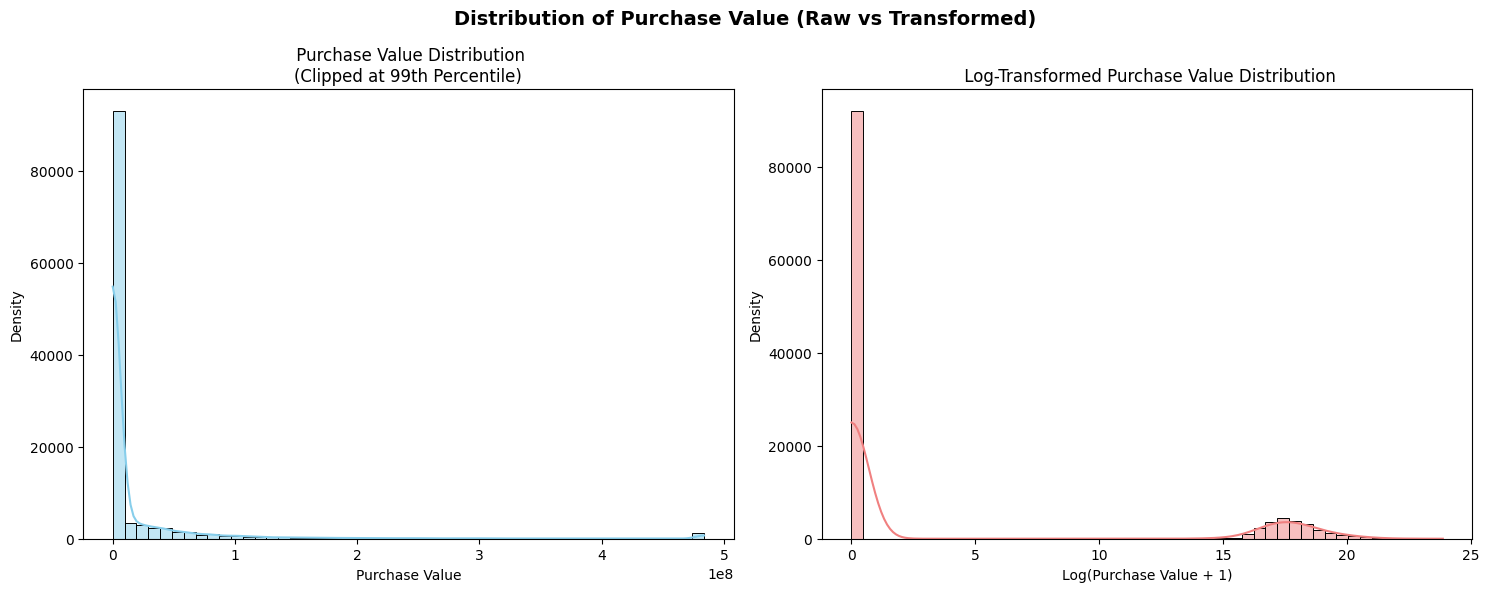


 Distribution Analysis:
   • Skewness value           : 53.91 (Right-skewed)
   • Interpretation           : Majority of customers spend very little, while a few spend a lot — typical of e-commerce & retail patterns.


In [13]:
print("\n \033[1mTARGET VARIABLE ANALYSIS: purchaseValue\033[0m")
print("=" * 50)

#  Basic descriptive statistics for the target variable
target_description = train_data['purchaseValue'].describe()
print(" \033[1mBasic Statistics:\033[0m")
print(target_description)

#  Calculate conversion metrics
conversion_rate = (train_data['purchaseValue'] > 0).mean() * 100
total_conversions = (train_data['purchaseValue'] > 0).sum()
total_non_conversions = (train_data['purchaseValue'] == 0).sum()

print("\n \033[1mKey Insights:\033[0m")
print(f"   • Conversion rate            : {conversion_rate:.2f}%")
print(f"   • Customers who purchased   : {total_conversions:,}")
print(f"   • Customers who didn’t buy  : {total_non_conversions:,}")
print(f"   • Average purchase value    : {target_description['mean']:.2f}")
print(f"   • Maximum purchase value    : {target_description['max']:.2f}")

# ==========================================
#  Visualization: Raw & Transformed Views
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#  Plot 1: Raw distribution (clipped to remove extreme outliers for clarity)
skewness = train_data['purchaseValue'].skew()
if skewness > 1:
    print(f"\n \033[1mSkewness:\033[0m {skewness:.2f} → Right-skewed distribution")

    # Clip extreme values at the 99th percentile to improve readability
    clipped_data = train_data['purchaseValue'].clip(upper=train_data['purchaseValue'].quantile(0.99))

    sns.histplot(clipped_data, bins=50, kde=True, ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title(' Purchase Value Distribution\n(Clipped at 99th Percentile)', fontsize=12)
    axes[0].set_xlabel('Purchase Value')
    axes[0].set_ylabel('Density')

    #  Plot 2: Log-transformed distribution to handle skewness
    log_data = np.log1p(train_data['purchaseValue'])  # log1p handles zero values safely

    sns.histplot(log_data, bins=50, kde=True, ax=axes[1], color='lightcoral', edgecolor='black')
    axes[1].set_title(' Log-Transformed Purchase Value Distribution', fontsize=12)
    axes[1].set_xlabel('Log(Purchase Value + 1)')
    axes[1].set_ylabel('Density')
else:
    # In case it's not skewed (not expected, but included for safety)
    sns.histplot(train_data['purchaseValue'], bins=50, kde=True, ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title(' Purchase Value Distribution', fontsize=12)
    axes[0].set_xlabel('Purchase Value')
    axes[0].set_ylabel('Density')

# Final touches
plt.suptitle('Distribution of Purchase Value (Raw vs Transformed)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

#  Key Insights
print("\n \033[1mDistribution Analysis:\033[0m")
print(f"   • Skewness value           : {skewness:.2f} (Right-skewed)")
print(f"   • Interpretation           : Majority of customers spend very little, while a few spend a lot — typical of e-commerce & retail patterns.")


In [14]:
# ---------------------------
# TRAFFIC SOURCE ANALYSIS
# ---------------------------

* Understanding where our customers come from is crucial for marketing strategy.
* We'll analyze different traffic sources to see which ones bring the most valuable customers.


 TRAFFIC SOURCE ANALYSIS
 Analysis by Traffic Medium:
                      Avg_Purchase  Total_Revenue  Total_Sessions  \
trafficSource.medium                                                
cpm                   2.153527e+08   1.727128e+11             802   
(none)                4.573531e+07   1.684752e+12           36837   
cpc                   1.827197e+07   7.831365e+10            4286   
referral              1.764453e+07   5.585730e+11           31657   
organic               1.442734e+07   5.865291e+11           40654   
(not set)             1.998000e+06   1.998000e+07              10   
affiliate             6.340180e+05   1.126650e+09            1777   

                      Unique_Users  
trafficSource.medium                
cpm                            620  
(none)                       32280  
cpc                           3904  
referral                     29874  
organic                      37436  
(not set)                        9  
affiliate                  

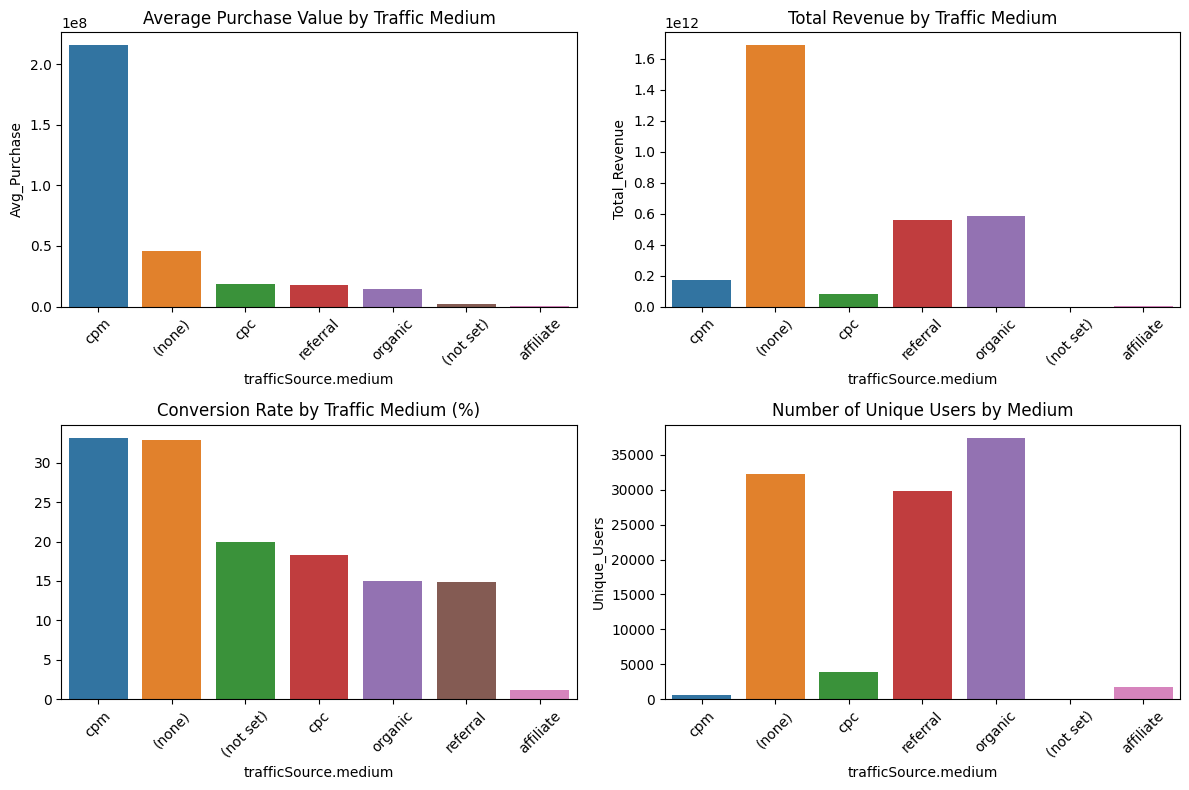


 Key Traffic Insights:
   • Best performing medium: cpm (215352668.33 avg purchase)
   • This tells us which marketing channels are most effective!


In [15]:
print("\n TRAFFIC SOURCE ANALYSIS")
print("=" * 50)

# Analyze by traffic medium
print(" Analysis by Traffic Medium:")
medium_analysis = train_data.groupby('trafficSource.medium').agg({
    'purchaseValue': ['mean', 'sum', 'count'],
    'userId': 'nunique'  # unique users per medium
}).round(2)

# Flatten column names for easier reading
medium_analysis.columns = ['Avg_Purchase', 'Total_Revenue', 'Total_Sessions', 'Unique_Users']
medium_analysis = medium_analysis.sort_values('Avg_Purchase', ascending=False)

print(medium_analysis)

# Visualize traffic medium performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.barplot(data=medium_analysis.reset_index(), x='trafficSource.medium', y='Avg_Purchase')
plt.title('Average Purchase Value by Traffic Medium')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.barplot(data=medium_analysis.reset_index(), x='trafficSource.medium', y='Total_Revenue')
plt.title('Total Revenue by Traffic Medium')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
conversionRate_by_medium = train_data.groupby('trafficSource.medium').apply(
    lambda x: (x['purchaseValue'] > 0).mean() * 100
).sort_values(ascending=False)
sns.barplot(x=conversionRate_by_medium.index, y=conversionRate_by_medium.values)
plt.title('Conversion Rate by Traffic Medium (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.barplot(data=medium_analysis.reset_index(), x='trafficSource.medium', y='Unique_Users')
plt.title('Number of Unique Users by Medium')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Key insights from traffic analysis
best_medium = medium_analysis.index[0]
best_avg_purchase = medium_analysis.loc[best_medium, 'Avg_Purchase']
print(f"\n Key Traffic Insights:")
print(f"   • Best performing medium: {best_medium} ({best_avg_purchase:.2f} avg purchase)")
print(f"   • This tells us which marketing channels are most effective!")


In [16]:
# ------------------------
#  DEVICE ANALYSIS
# ------------------------

Understanding the technology our customers use helps us:
1. Optimize our website for their preferred devices
2. Identify which platforms generate more revenue
3. Plan our development priorities


 DEVICE AND TECHNOLOGY ANALYSIS
 Mobile vs Desktop Performance:
         Avg_Purchase  Total_Revenue  Sessions  Unique_Users
Desktop   34241675.49   2.961699e+12     86494         72867
Mobile     4074888.41   1.203274e+11     29529         27637


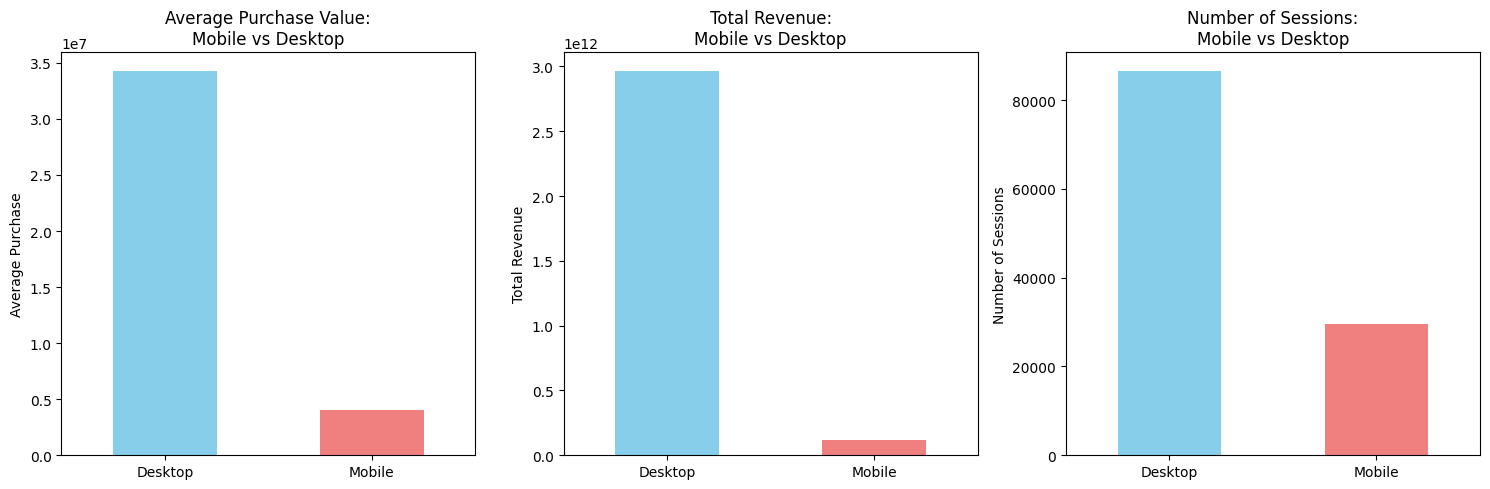


 Device Type Breakdown:
                    mean  count
deviceType                     
desktop     3.424728e+07  86480
tablet      5.091584e+06   3693
mobile      3.927222e+06  25850


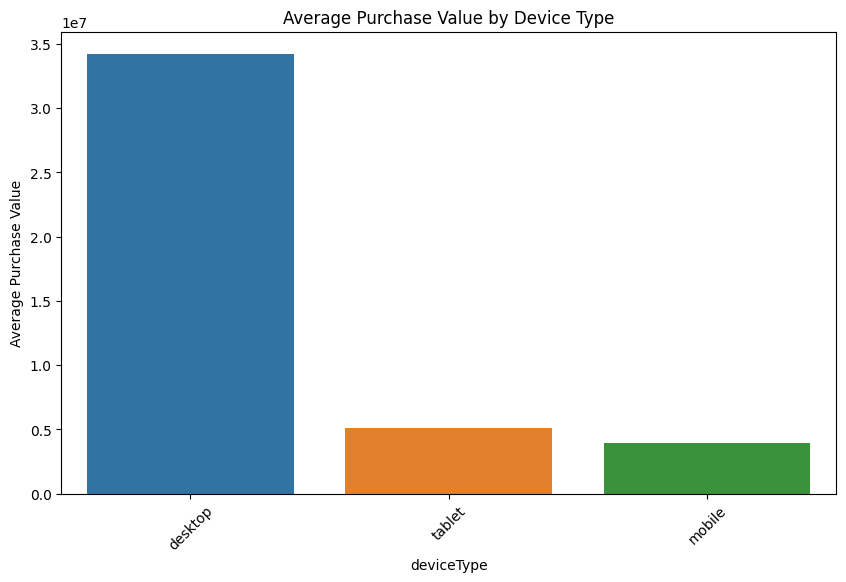


 Top Browser Performance:
                           mean  count
browser                               
Firefox            5.678158e+07   4031
Chrome             3.217082e+07  84508
Edge               1.023996e+07   1216
Internet Explorer  7.490626e+06   2155
Safari             5.451599e+06  19184
Safari (in-app)    3.689660e+05    793
Android Webview    1.105910e+05   1472
Opera Mini         0.000000e+00    733


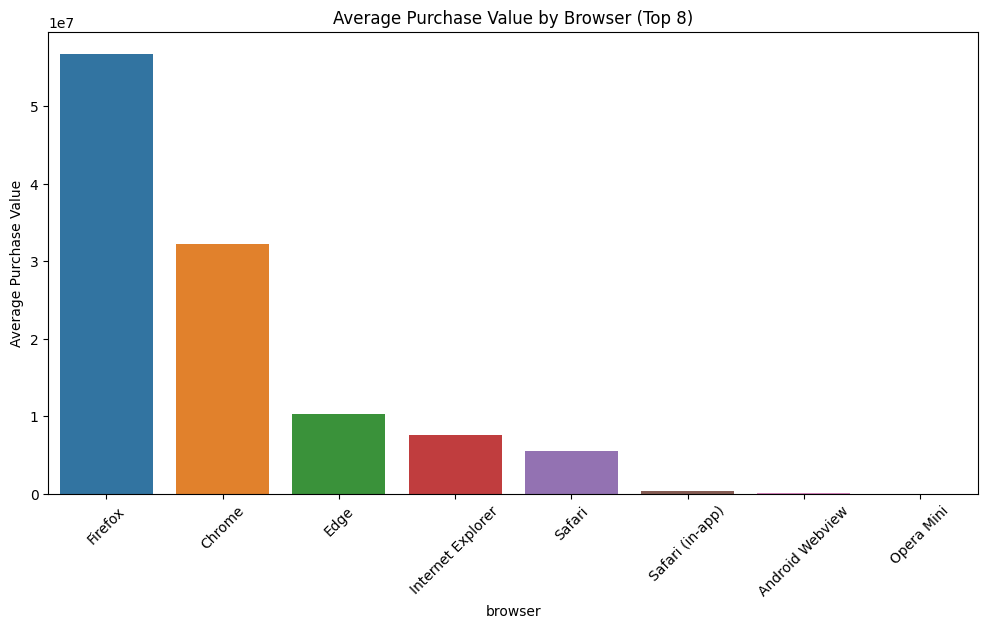


Purchase value by operating system:
                          mean  count
os                                   
Chrome OS         7.506782e+07   4743
Macintosh         4.543571e+07  37659
Windows           2.058279e+07  39135
Linux             1.784342e+07   5075
Android           4.511533e+06  15866
iOS               3.700139e+06  12762
Windows Phone     5.557895e+05     95
Playstation Vita  0.000000e+00      2
Xbox              0.000000e+00      9
Tizen             0.000000e+00     22
Samsung           0.000000e+00     46
(not set)         0.000000e+00    565
OS/2              0.000000e+00      4
Nintendo Wii      0.000000e+00     14
FreeBSD           0.000000e+00      1
Firefox OS        0.000000e+00      1
BlackBerry        0.000000e+00     18
Nintendo WiiU     0.000000e+00      6


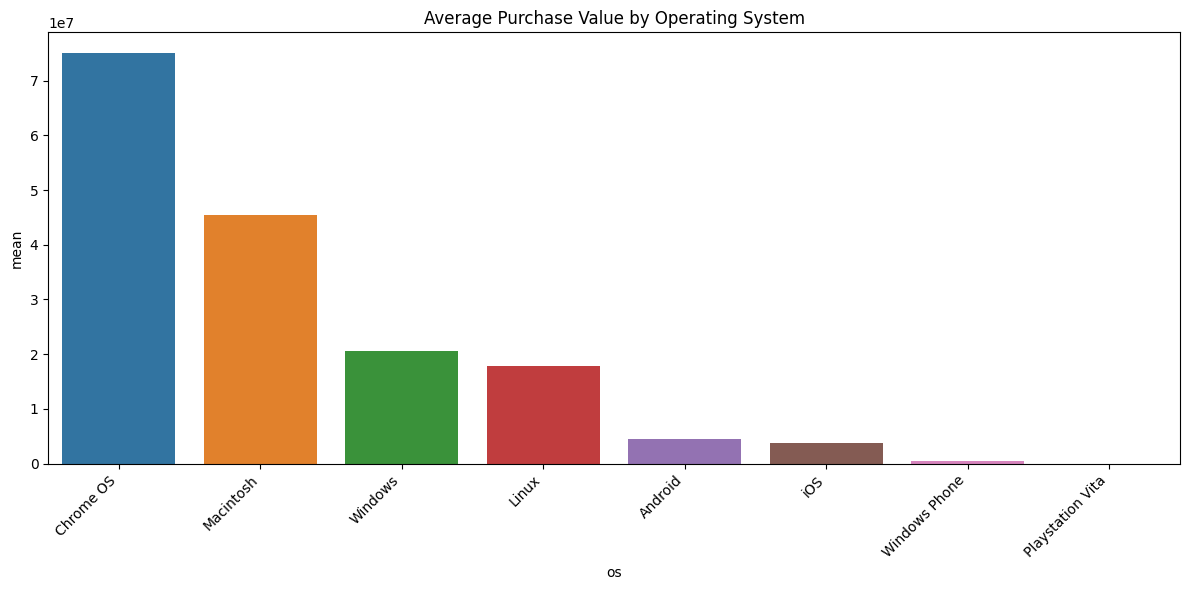


 Device Insights:
   • Best converting device: desktop
   • Best operating system: Chrome OS
   • Mobile vs Desktop: Desktop wins!


In [17]:
print("\n DEVICE AND TECHNOLOGY ANALYSIS")
print("=" * 50)

# Mobile vs Desktop analysis
print(" Mobile vs Desktop Performance:")
mobile_analysis = train_data.groupby('device.isMobile').agg({
    'purchaseValue': ['mean', 'sum', 'count'],
    'userId': 'nunique'
}).round(2)
mobile_analysis.columns = ['Avg_Purchase', 'Total_Revenue', 'Sessions', 'Unique_Users']
mobile_analysis.index = ['Desktop', 'Mobile']  
print(mobile_analysis)

# Visualize mobile vs desktop
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Average purchase value
mobile_analysis['Avg_Purchase'].plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Average Purchase Value:\nMobile vs Desktop')
axes[0].set_ylabel('Average Purchase')
axes[0].set_xticklabels(['Desktop', 'Mobile'], rotation=0)

# Plot 2: Total revenue
mobile_analysis['Total_Revenue'].plot(kind='bar', ax=axes[1], color=['skyblue', 'lightcoral'])
axes[1].set_title('Total Revenue:\nMobile vs Desktop')
axes[1].set_ylabel('Total Revenue')
axes[1].set_xticklabels(['Desktop', 'Mobile'], rotation=0)

# Plot 3: Number of sessions
mobile_analysis['Sessions'].plot(kind='bar', ax=axes[2], color=['skyblue', 'lightcoral'])
axes[2].set_title('Number of Sessions:\nMobile vs Desktop')
axes[2].set_ylabel('Number of Sessions')
axes[2].set_xticklabels(['Desktop', 'Mobile'], rotation=0)

plt.tight_layout()
plt.show()

# Device type analysis (smartphone, tablet, desktop)
print("\n Device Type Breakdown:")
device_analysis = train_data.groupby('deviceType')['purchaseValue'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(device_analysis)

plt.figure(figsize=(10, 6))
sns.barplot(x=device_analysis.index, y='mean', data=device_analysis)
plt.title('Average Purchase Value by Device Type')
plt.ylabel('Average Purchase Value')
plt.xticks(rotation=45)
plt.show()

# Browser analysis (top browsers only)
print("\n Top Browser Performance:")
top_browsers = train_data['browser'].value_counts().head(8).index
browser_analysis = train_data[train_data['browser'].isin(top_browsers)].groupby('browser')['purchaseValue'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(browser_analysis)

plt.figure(figsize=(12, 6))
sns.barplot(x=browser_analysis.index, y='mean', data=browser_analysis)
plt.title('Average Purchase Value by Browser (Top 8)')
plt.ylabel('Average Purchase Value')
plt.xticks(rotation=45)
plt.show()


# Analyze by operating system
plt.figure(figsize=(12, 6))
os_purchase = train_data.groupby('os')['purchaseValue'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print("\nPurchase value by operating system:")
print(os_purchase)
sns.barplot(x=os_purchase.index[:8], y='mean', data=os_purchase[:8])
plt.title('Average Purchase Value by Operating System')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


print(f"\n Device Insights:")
best_device = device_analysis.index[0]
best_os = os_purchase.index[0]
print(f"   • Best converting device: {best_device}")
print(f"   • Best operating system: {best_os}")
print(f"   • Mobile vs Desktop: {'Mobile wins!' if mobile_analysis.loc['Mobile', 'Avg_Purchase'] > mobile_analysis.loc['Desktop', 'Avg_Purchase'] else 'Desktop wins!'}")

In [18]:
# ---------------------------
#  GEOGRAPHIC ANALYSIS
# ---------------------------

Geography can significantly impact purchasing behavior due to:
- Economic differences between regions
- Cultural preferences
- Local marketing campaigns
- Seasonal variations


 GEOGRAPHIC ANALYSIS
Purchase Behavior by Continent:
                      Avg_Purchase  Total_Revenue  Sessions  Unique_Users
geoNetwork.continent                                                     
Americas               43043345.60   3.006836e+12     69856         56131
Africa                  8218906.70   1.435843e+10      1747          1717
(not set)               6768382.35   9.205000e+08       136           124
Oceania                 4801270.24   7.710840e+09      1606          1554
Asia                    1645135.36   3.682471e+10     22384         21554
Europe                   757683.55   1.537643e+10     20294         19478


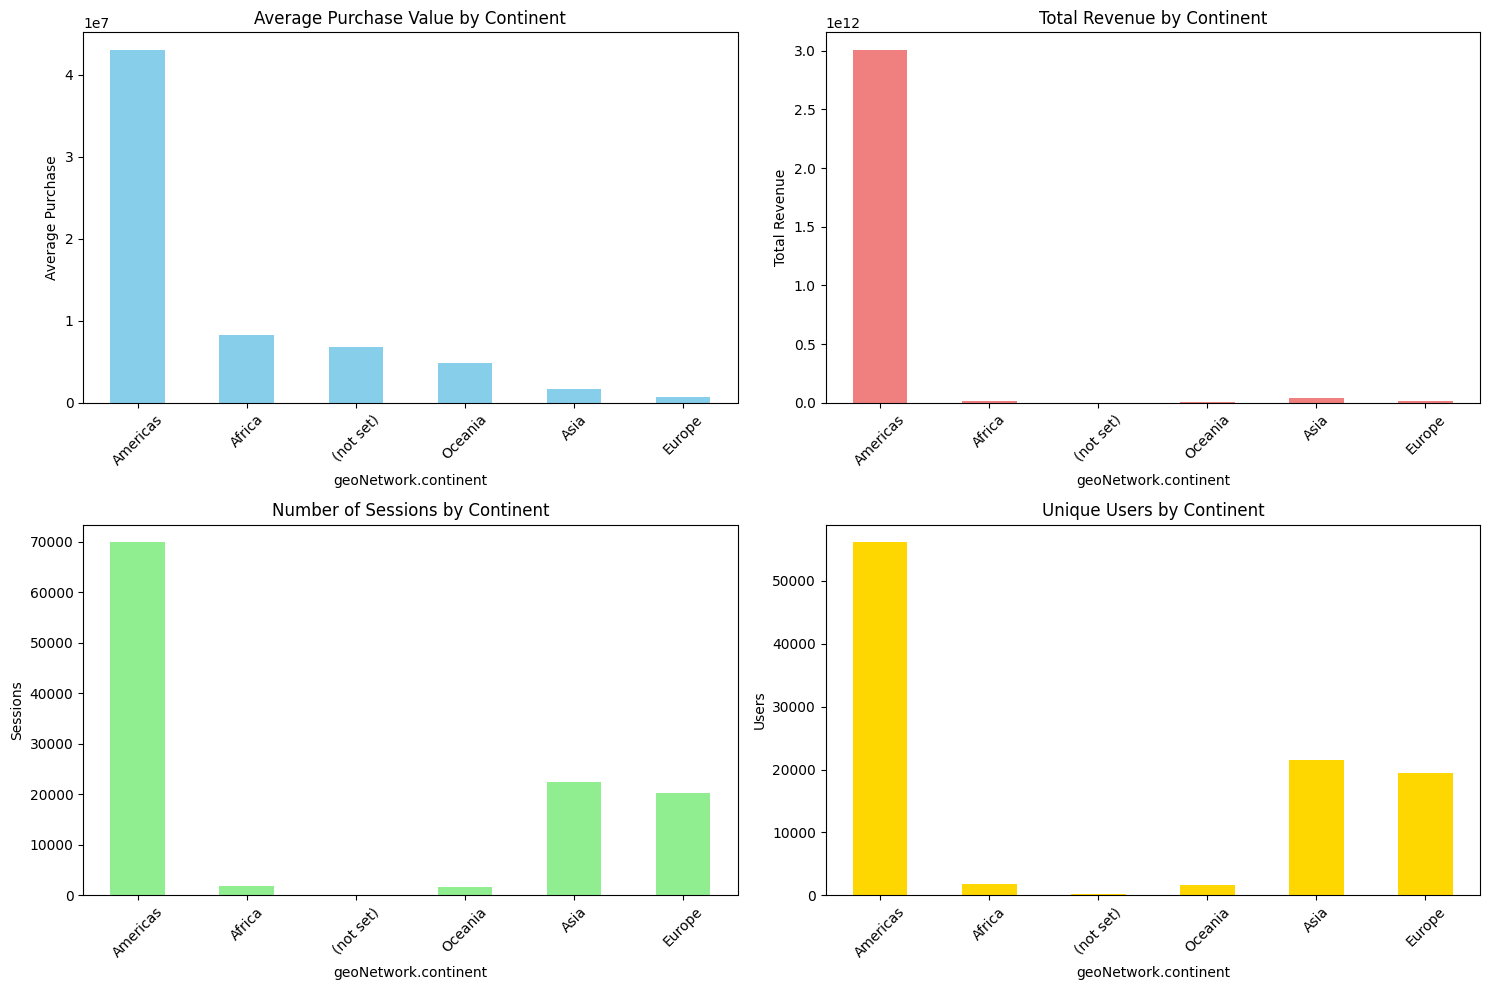


 Top 10 Countries by Average Purchase Value:
                         mean  count
locationCountry                     
Kenya            1.302603e+08     68
Venezuela        7.071821e+07    290
United States    4.826599e+07  60369
Puerto Rico      2.866931e+07     87
Nigeria          2.640829e+07    193
Canada           1.866913e+07   3226
Ecuador          8.195873e+06    126
Japan            6.797011e+06   2031
(not set)        6.768382e+06    136
Hong Kong        6.676448e+06    487


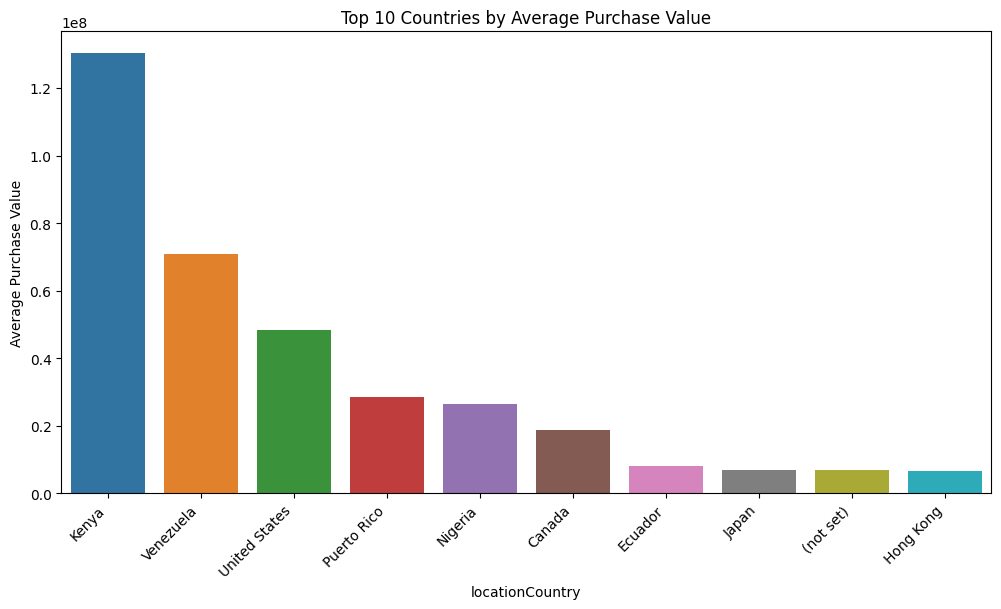


 Geographic Insights:
   • Best performing continent: Americas
   • Best performing country: Kenya
   • This information is crucial for targeted marketing campaigns!


In [19]:
print("\n GEOGRAPHIC ANALYSIS")
print("=" * 50)

# Continental analysis
print("Purchase Behavior by Continent:")
continent_analysis = train_data.groupby('geoNetwork.continent').agg({
    'purchaseValue': ['mean', 'sum', 'count'],
    'userId': 'nunique'
}).round(2)
continent_analysis.columns = ['Avg_Purchase', 'Total_Revenue', 'Sessions', 'Unique_Users']
continent_analysis = continent_analysis.sort_values('Avg_Purchase', ascending=False)
print(continent_analysis)

# Visualize continental performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

continent_analysis['Avg_Purchase'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Average Purchase Value by Continent')
axes[0,0].set_ylabel('Average Purchase')
axes[0,0].tick_params(axis='x', rotation=45)

continent_analysis['Total_Revenue'].plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Total Revenue by Continent')
axes[0,1].set_ylabel('Total Revenue')
axes[0,1].tick_params(axis='x', rotation=45)

continent_analysis['Sessions'].plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Number of Sessions by Continent')
axes[1,0].set_ylabel('Sessions')
axes[1,0].tick_params(axis='x', rotation=45)

continent_analysis['Unique_Users'].plot(kind='bar', ax=axes[1,1], color='gold')
axes[1,1].set_title('Unique Users by Continent')
axes[1,1].set_ylabel('Users')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Top countries analysis
print("\n Top 10 Countries by Average Purchase Value:")
country_analysis = train_data.groupby('locationCountry')['purchaseValue'].agg(['mean', 'count'])
country_analysis = country_analysis[country_analysis['count'] > 50]  # Countries with significant data
top_countries = country_analysis.sort_values('mean', ascending=False).head(10)
print(top_countries)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y='mean', data=top_countries)
plt.title('Top 10 Countries by Average Purchase Value')
plt.ylabel('Average Purchase Value')
plt.xticks(rotation=45, ha='right')
plt.show()

best_continent = continent_analysis.index[0]
best_country = top_countries.index[0]
print(f"\n Geographic Insights:")
print(f"   • Best performing continent: {best_continent}")
print(f"   • Best performing country: {best_country}")
print(f"   • This information is crucial for targeted marketing campaigns!")


In [20]:
# ---------------------------
#  SESSION BEHAVIOR ANALYSIS
# ---------------------------

Session analysis helps us understand the customer journey:
- Do customers convert on their first visit?
- How many sessions does it typically take to convert?
- What's the relationship between session number and purchase behavior?


 SESSION BEHAVIOR ANALYSIS
 Purchase Behavior by Session Number:
                  Avg_Purchase  Total_Revenue  Conversion_Rate  Session_Count
sessionNumberBin                                                             
1st               9.795661e+06   7.887270e+11            11.63          80518
2nd               3.697820e+07   5.460201e+11            35.03          14766
3rd               5.589494e+07   3.701922e+11            43.74           6623
4-5th             7.079795e+07   4.318675e+11            48.90           6100
6-10th            9.162238e+07   4.242116e+11            49.14           4630
11-20th           1.173069e+08   2.298043e+11            42.62           1959
21-50th           9.462553e+07   8.421672e+10            35.96            890
50+               3.854516e+08   2.069875e+11            26.44            537


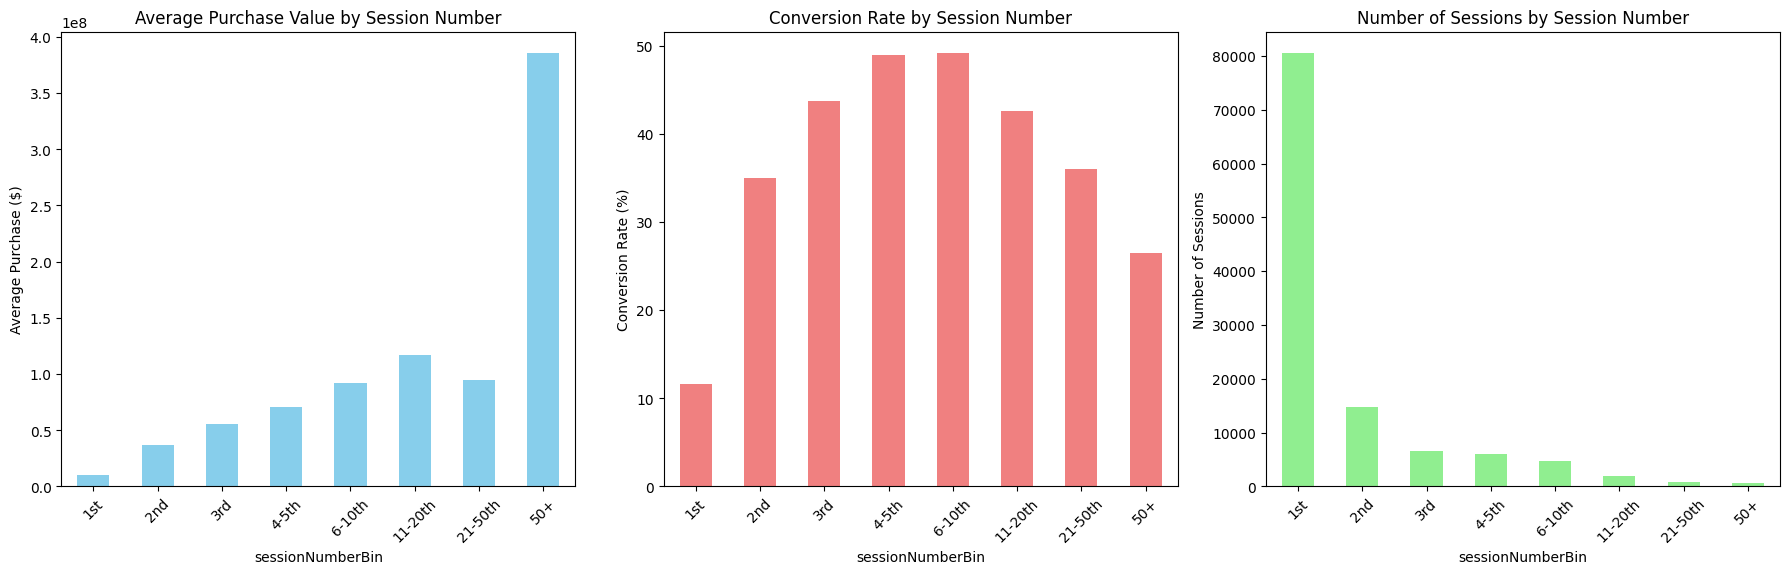


 Session Insights:
   • First session conversion rate: 11.63%
   • This tells us how many customers convert immediately vs. need nurturing!


In [21]:
print("\n SESSION BEHAVIOR ANALYSIS")
print("=" * 50)

# Session number analysis
print(" Purchase Behavior by Session Number:")

# Create meaningful bins for session numbers
session_bins = [0, 1, 2, 3, 5, 10, 20, 50, np.inf]
session_labels = ['1st', '2nd', '3rd', '4-5th', '6-10th', '11-20th', '21-50th', '50+']
#Divide a continuous numeric column into discrete bins (categories).
train_data['sessionNumberBin'] = pd.cut(train_data['sessionNumber'], bins=session_bins, labels=session_labels)

session_analysis = train_data.groupby('sessionNumberBin').agg({
    'purchaseValue': ['mean', 'sum', lambda x: (x > 0).mean() * 100],
    'userId': 'count'
}).round(2)
session_analysis.columns = ['Avg_Purchase', 'Total_Revenue', 'Conversion_Rate', 'Session_Count']
print(session_analysis)

# Visualize session behavior
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

session_analysis['Avg_Purchase'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Average Purchase Value by Session Number')
axes[0].set_ylabel('Average Purchase ($)')
axes[0].set_xticklabels(session_analysis.index, rotation=45)

session_analysis['Conversion_Rate'].plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Conversion Rate by Session Number')
axes[1].set_ylabel('Conversion Rate (%)')
axes[1].set_xticklabels(session_analysis.index, rotation=45)

session_analysis['Session_Count'].plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Number of Sessions by Session Number')
axes[2].set_ylabel('Number of Sessions')
axes[2].set_xticklabels(session_analysis.index, rotation=45)

plt.tight_layout()
plt.show()

print(f"\n Session Insights:")
first_session_conv = session_analysis.loc['1st', 'Conversion_Rate']
print(f"   • First session conversion rate: {first_session_conv:.2f}%")
print(f"   • This tells us how many customers convert immediately vs. need nurturing!")

train_data.drop(columns = ['sessionNumberBin'], inplace = True)

In [22]:
# ---------------------------
#  CORRELATION ANALYSIS
# ---------------------------

Correlation analysis helps us understand relationships between different features.
This is crucial for:
1. Feature selection in machine learning models
2. Understanding what drives purchases
3. Identifying redundant features


 CORRELATION ANALYSIS
 Analyzing correlations for 7 key features:
Features included: userId, sessionNumber, sessionId, pageViews, totalHits, sessionStart, purchaseValue

 Correlations with Purchase Value:
purchaseValue    1.000000
totalHits        0.251651
pageViews        0.248454
sessionNumber    0.230585
userId          -0.003469
sessionStart    -0.018537
sessionId       -0.018537
Name: purchaseValue, dtype: float64


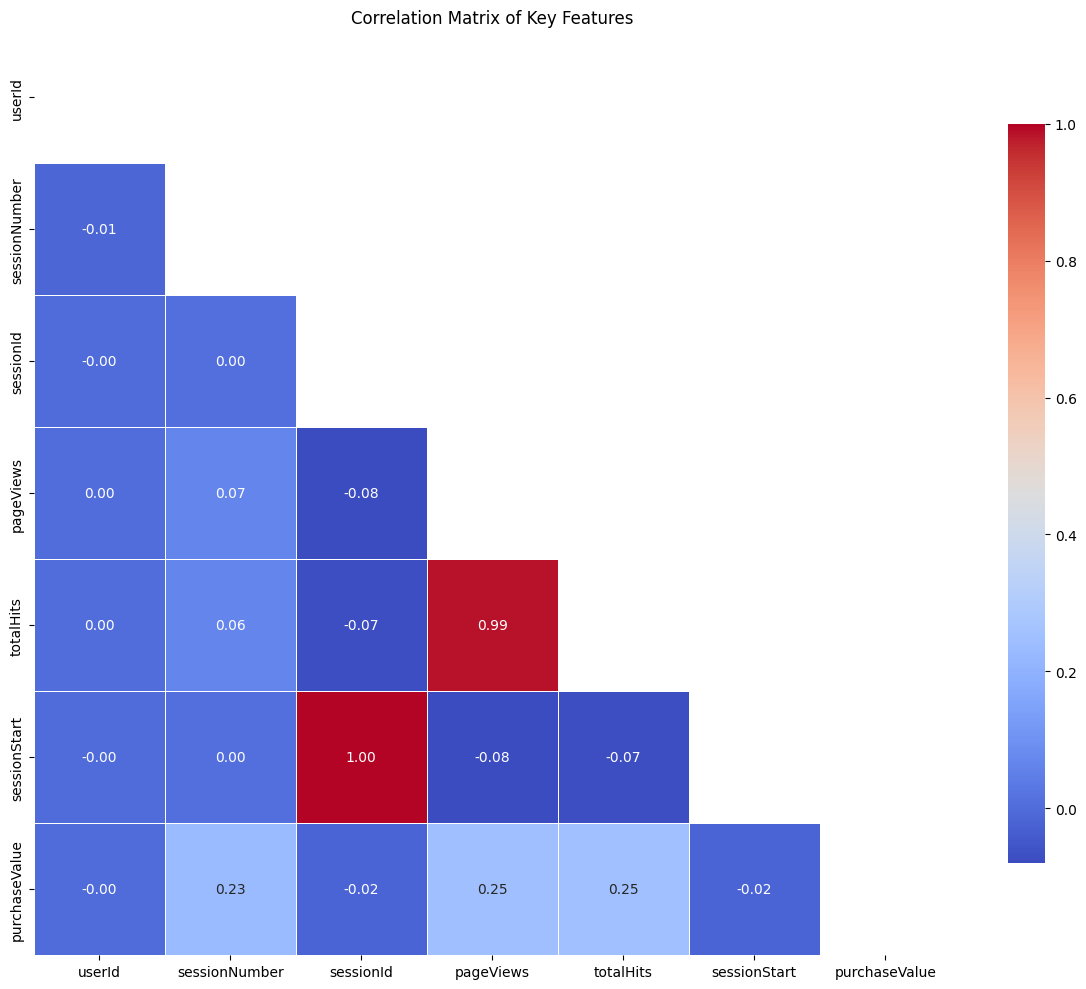


 Features most correlated with purchases:
   • totalHits: 0.252 (weakly positively correlated)
   • pageViews: 0.248 (weakly positively correlated)
   • sessionNumber: 0.231 (weakly positively correlated)


In [23]:
print("\n CORRELATION ANALYSIS")
print("=" * 50)

# Select key numeric features for correlation analysis
numeric_cols = train_data.select_dtypes(include=['number']).columns
key_features = [col for col in numeric_cols if col != 'purchaseValue' and train_data[col].nunique() > 5]
key_features = [col for col in key_features if train_data[col].isnull().sum() / len(train_data) < 0.5]
key_features.append('purchaseValue')

print(f" Analyzing correlations for {len(key_features)} key features:")
print("Features included:", ', '.join(key_features))

# Calculate correlation matrix
corr_matrix = train_data[key_features].corr()

# Show correlations with purchase value
purchase_correlations = corr_matrix['purchaseValue'].sort_values(ascending=False)
print(f"\n Correlations with Purchase Value:")
print(purchase_correlations)

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Show only lower triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Key Features')
plt.tight_layout()
plt.show()

# Identify strongest correlations (excluding perfect correlation with itself)
strong_correlations = purchase_correlations[(abs(purchase_correlations) > 0.1) & (purchase_correlations.index != 'purchaseValue')]
print(f"\n Features most correlated with purchases:")
for feature, corr in strong_correlations.items():
    direction = "positively" if corr > 0 else "negatively"
    strength = "strongly" if abs(corr) > 0.5 else "moderately" if abs(corr) > 0.3 else "weakly"
    print(f"   • {feature}: {corr:.3f} ({strength} {direction} correlated)")

In [24]:
# ---------------------------
#  DATA QUALITY ANALYSIS
# ---------------------------

Understanding missing data patterns is crucial because:
1. Missing data might not be random (could indicate specific user behaviors)
2. It affects our model performance
3. We need to decide how to handle it


 DATA QUALITY ANALYSIS
 Missing Value Analysis:
Total features: 52
Features with missing data: 11
Features with >10% missing: 10

 Top Missing Value Patterns:
trafficSource.adContent                         97.446196
trafficSource.adwordsClickInfo.slot             96.310214
trafficSource.adwordsClickInfo.isVideoAd        96.310214
trafficSource.adwordsClickInfo.adNetworkType    96.310214
trafficSource.adwordsClickInfo.page             96.310214
trafficSource.referralPath                      63.184886
trafficSource.isTrueDirect                      63.033192
trafficSource.keyword                           61.936857
totals.bounces                                  59.363230
new_visits                                      30.601691
dtype: float64


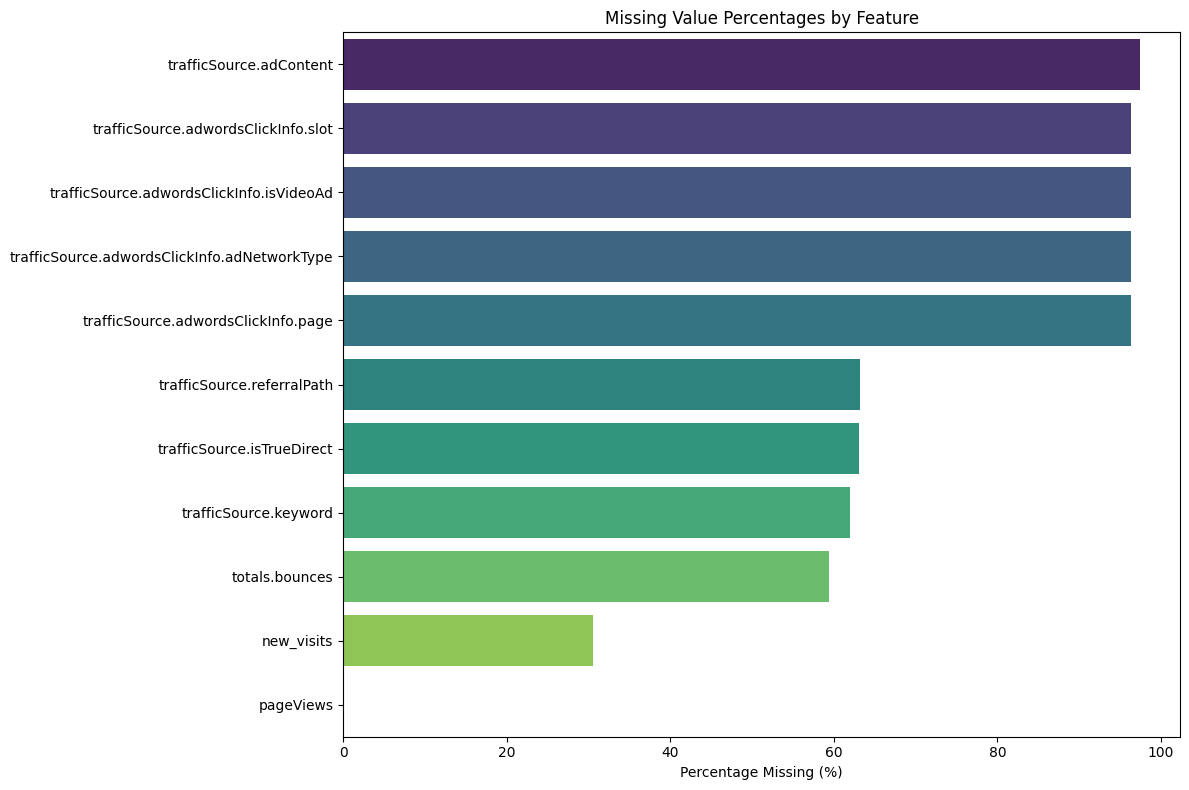

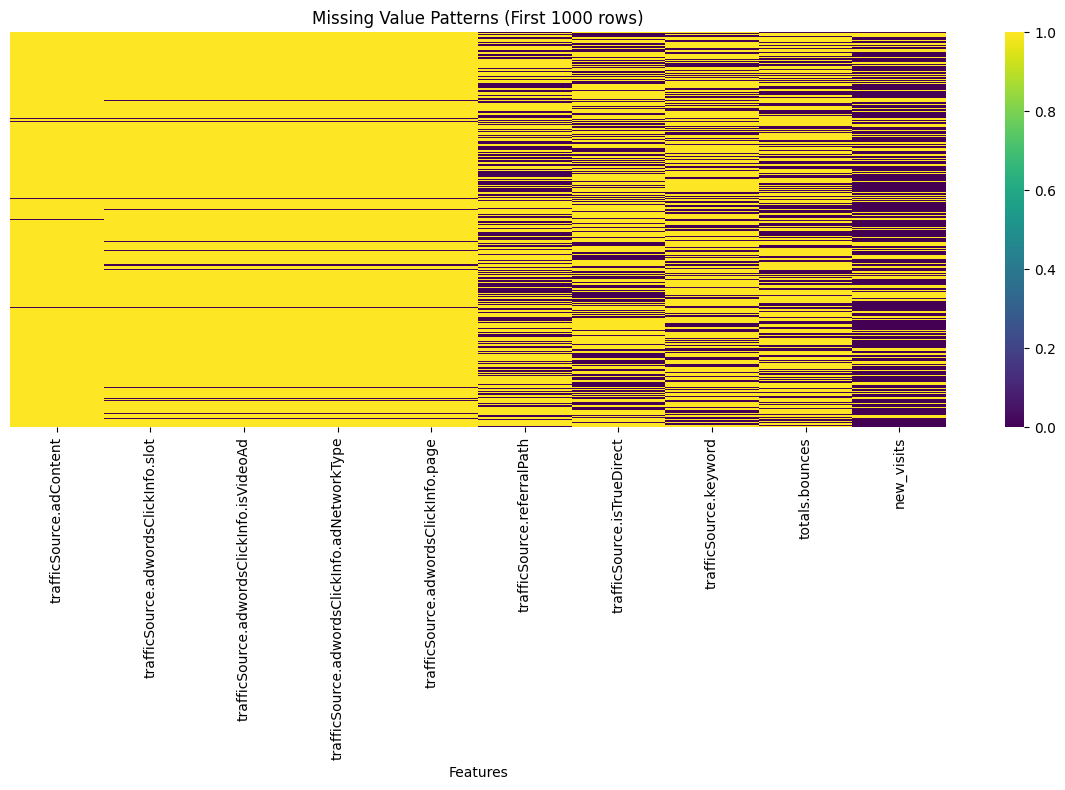


 Data Quality Insights:
   • 11 features have missing values
   • Consider imputation strategies for features with <20% missing
   • Features with >50% missing might need to be dropped


In [25]:
print("\n DATA QUALITY ANALYSIS")
print("=" * 50)

# Analyze missing values
missing_percentages = train_data.isnull().mean() * 100
missing_data = missing_percentages[missing_percentages > 0].sort_values(ascending=False)

print(" Missing Value Analysis:")
print(f"Total features: {len(train_data.columns)}")
print(f"Features with missing data: {len(missing_data)}")
print(f"Features with >10% missing: {len(missing_data[missing_data > 10])}")

print(f"\n Top Missing Value Patterns:")
print(missing_data.head(10))

# Visualize missing patterns
if len(missing_data) > 0:
    # Plot missing value percentages
    plt.figure(figsize=(12, 8))
    top_missing = missing_data.head(15)
    sns.barplot(x=top_missing.values, y=top_missing.index, palette='viridis')
    plt.title('Missing Value Percentages by Feature')
    plt.xlabel('Percentage Missing (%)')
    plt.tight_layout()
    plt.show()
    
    # Heatmap of missing patterns (for features with >5% missing)
    high_missing_features = missing_data[missing_data > 5].index
    if len(high_missing_features) > 0:
        plt.figure(figsize=(12, 8))
        sns.heatmap(train_data[high_missing_features].head(1000).isnull(), 
                   cmap='viridis', yticklabels=False, cbar=True)
        plt.title('Missing Value Patterns (First 1000 rows)')
        plt.xlabel('Features')
        plt.tight_layout()
        plt.show()

print(f"\n Data Quality Insights:")
print(f"   • {len(missing_data)} features have missing values")
print(f"   • Consider imputation strategies for features with <20% missing")
print(f"   • Features with >50% missing might need to be dropped")

In [26]:
# ---------------------------
# TEMPORAL ANALYSIS
# ---------------------------


 TEMPORAL ANALYSIS


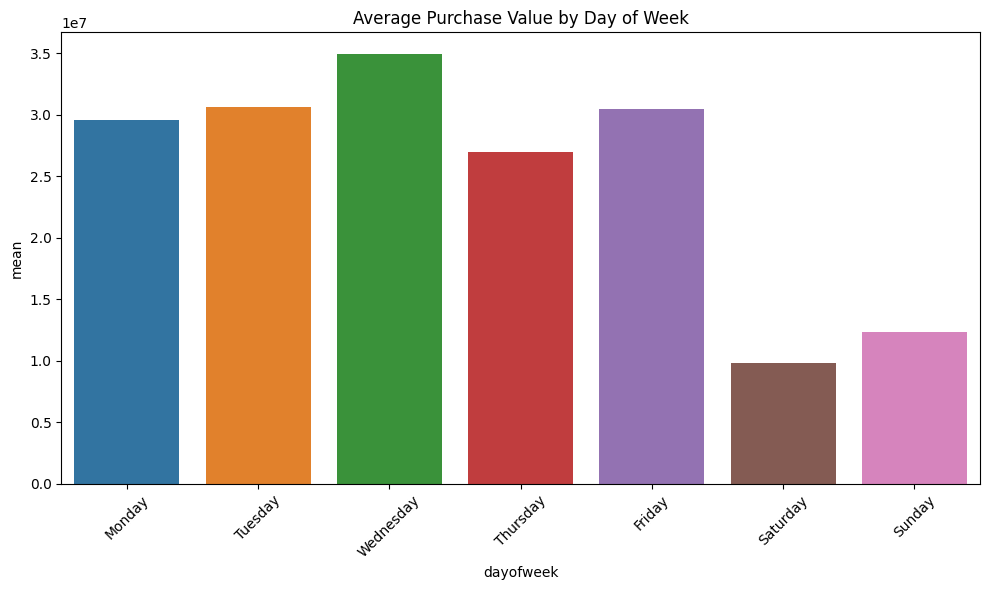

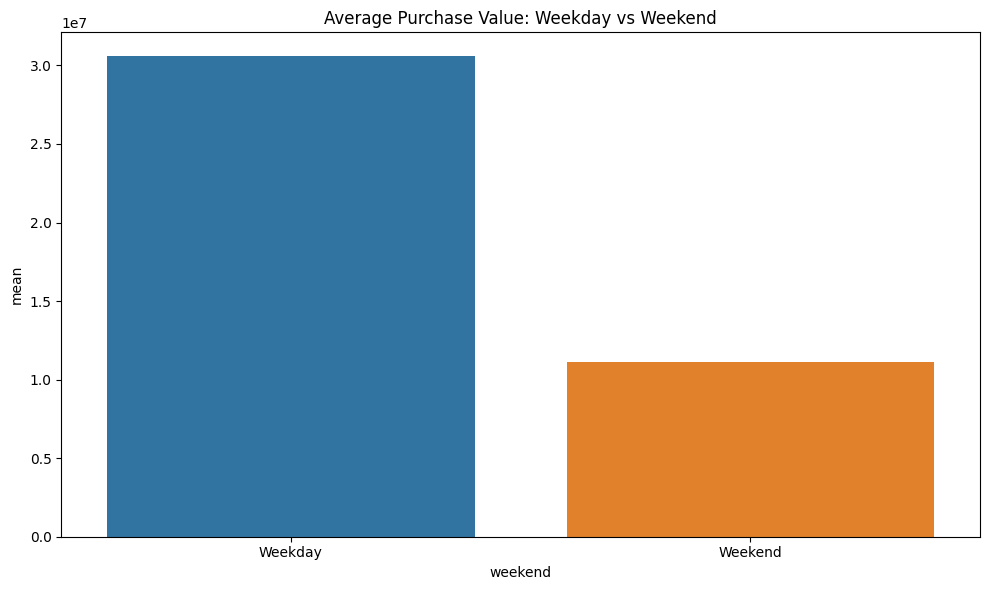

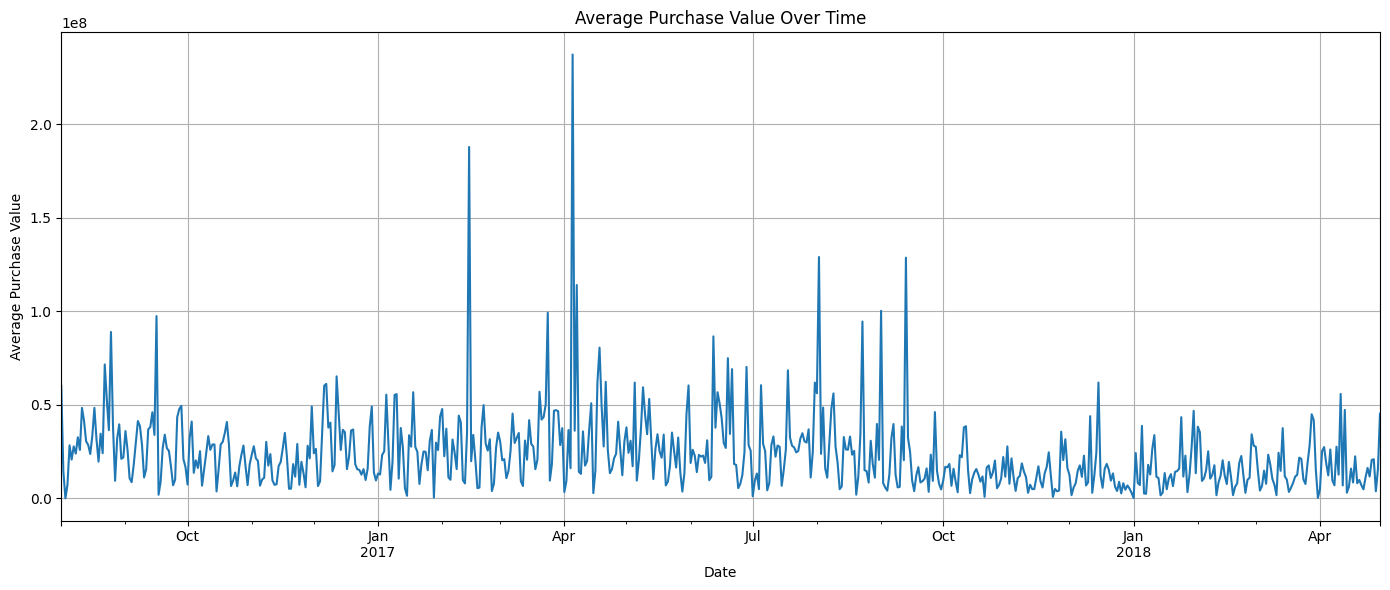

In [27]:
print("\n TEMPORAL ANALYSIS")  #the study of data over time to identify patterns, trends, and relationships
print("=" * 50)

if 'date' in train_data.columns:
    
    # Extract time components directly from datetime column
    train_data['date_year'] = train_data['date'].dt.year
    train_data['date_month'] = train_data['date'].dt.month
    train_data['date_day'] = train_data['date'].dt.day
    train_data['dayofweek'] = train_data['date'].dt.dayofweek
    train_data['weekend'] = train_data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    train_data['date_weekday_name'] = train_data['date'].dt.day_name()

    # Analyze purchase value by day of week
    plt.figure(figsize=(10, 6))
    dow_purchase = train_data.groupby('dayofweek')['purchaseValue'].agg(['mean', 'count'])
    dow_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    sns.barplot(x=dow_purchase.index, y='mean', data=dow_purchase)
    plt.title('Average Purchase Value by Day of Week')
    plt.xticks(range(7), dow_labels, rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Analyze by weekend vs weekday
    plt.figure(figsize=(10, 6))
    weekend_purchase = train_data.groupby('weekend')['purchaseValue'].agg(['mean', 'count'])
    weekend_labels = ['Weekday', 'Weekend']
    sns.barplot(x=weekend_purchase.index, y='mean', data=weekend_purchase)
    plt.title('Average Purchase Value: Weekday vs Weekend')
    plt.xticks(range(2), weekend_labels)
    plt.tight_layout()
    plt.show()
    
    # Time series of average purchase value by date
    plt.figure(figsize=(14, 6))
    time_purchase = train_data.groupby('date')['purchaseValue'].mean()
    time_purchase.plot()
    plt.title('Average Purchase Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Purchase Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_data.drop(columns = ['weekend', 'dayofweek', 'date_year','date_month','date_day','date_weekday_name'], inplace = True)

In [28]:
# ---------------------------
# SUMMARY OF FINDINGS
# ---------------------------

**SUMMARY OF KEY FINDINGS**

🎯 **Target Variable –** purchaseValue

* The dataset exhibits a **highly right-skewed distribution** of purchase values, with a **skewness of 53.91**, indicating that most users make little or no purchases, while a few account for extremely high values.

* **Conversion Rate:** 20.67% of users made a purchase.

* **Total Purchasers:** 23,985 | **Non-Purchasers:** 92,038

* **Average Purchase Value:** ₹26.56M

* **Maximum Purchase Value:** ₹23.13B (strong outlier presence)

🚦 **Traffic Source Analysis**

* **Top Medium by Avg. Purchase:** cpm with ₹215M+, though with limited reach.

* **Top Medium by Revenue & Users:** (none) (direct traffic), with over ₹1.68T revenue and 32,280 unique users.

* **Underperformers:** affiliate and (not set) have low conversions and revenue.

* **Insight:** Direct and cpm-based campaigns drive high-value customers, while organic and referral sources deliver high volume but moderate performance.

📱 **Device and Technology Insights**

* **Desktop users dominate** in both purchase volume and revenue.

    * **Avg Purchase:** ₹34.24M (Desktop) vs ₹4.07M (Mobile)

* **Best-performing Operating System:** Chrome OS, followed by Macintosh and Windows.

* **Top Browser:** Firefox users have the highest average purchase, followed by Chrome.

* **Insight:** Optimizing desktop and Chrome OS experiences could enhance ROI.

🌍 **Geographic Insights**

* **Top Performing Continent:** Americas with an average purchase of ₹43M.

* **Top Country by Avg Purchase:** Kenya (₹130M), followed by Venezuela and the U.S.

* **Insight:** The Americas and select African markets offer significant revenue opportunities, and merit further targeted campaigns.

🔄 **Session Behavior Analysis**

* Conversion increases with session depth:

    * 1st session: 11.63% conversion
    
    * 4–5 sessions: ~49% conversion
    
    * 6–10 sessions: ~49% conversion

* Highest Avg Purchase: Seen in users with **50+ sessions** (~₹385M), indicating value in retention and engagement.

* **Insight:** Repeat visits are strongly associated with higher conversions and spending — remarketing and nurturing are essential.

🔗 **Correlation Analysis**

* **Top correlated features with purchases:**

    * totalHits (0.25)
    
    * pageViews (0.25)
    
    * sessionNumber (0.23)

* These indicate a weak but positive relationship between engagement metrics and likelihood of purchase.

* **Insight:** Increased session interaction (hits/views) modestly correlates with purchase behavior.

# Data Cleaning

In [29]:
#  Remove duplicate rows to ensure data quality and avoid bias in analysis/modeling
train_data.drop_duplicates(inplace=True)


In [30]:
def drop_low_variability_columns(df, threshold=1):
    """
     Drops columns from the DataFrame that have low variability (i.e., nearly constant values).
    
     Why?
    - Columns with only 1 unique value don't provide useful information to most machine learning models.
    - They can be removed to reduce noise, dimensionality, and computational load.

    Parameters:
    - df (pd.DataFrame): The input DataFrame to be cleaned.
    - threshold (int): Maximum number of unique values to consider a column as "low variability".
                       Default is 1 (drop columns with only 1 unique value, including NaNs if present).

    Returns:
    - None: This function modifies the DataFrame in-place.
    """
    
    # Identify columns with low variability (≤ threshold unique values)
    low_var_cols = [col for col in df.columns if df[col].nunique(dropna=False) <= threshold]

    if low_var_cols:
        # Log the columns being dropped
        print(f"\033[1mDropping columns with ≤ {threshold} unique value(s):\033[0m\n{low_var_cols}")
        
        # Drop those columns from the DataFrame
        df.drop(columns=low_var_cols, inplace=True)
    else:
        print(f"\033[1mNo columns found with ≤ {threshold} unique value(s).\033[0m")

# Apply the function to both training and test datasets to ensure consistency
drop_low_variability_columns(train_data, threshold=1)
drop_low_variability_columns(test_data, threshold=1)


Dropping columns with ≤ 1 unique value(s):
['device.screenResolution', 'screenSize', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'device.mobileDeviceMarketingName', 'device.operatingSystemVersion', 'device.flashVersion', 'totals.visits', 'geoNetwork.networkLocation', 'browserMajor', 'device.browserSize', 'socialEngagementType', 'locationZone', 'device.mobileDeviceModel', 'device.language', 'device.browserVersion', 'device.screenColors']
Dropping columns with ≤ 1 unique value(s):
['device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.networkLocation', 'socialEngagementType', 'totals.visits', 'locationZone', 'browserMajor', 'screenSize']


In [31]:
train_data['trafficSource.isTrueDirect'].fillna(False, inplace=True)
train_data['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
train_data['trafficSource.adwordsClickInfo.page'].fillna(0, inplace=True)
train_data['totalHits'] = train_data['totalHits'].astype(int)

test_data['trafficSource.isTrueDirect'].fillna(False, inplace=True)
test_data['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
test_data['trafficSource.adwordsClickInfo.page'].fillna(0, inplace=True)
test_data['totalHits'] = test_data['totalHits'].astype(int)

In [32]:
# Create a binary feature 'is_bounced': 1 if the session was a bounce (totals.bounces == 1), else 0
train_data['is_bounced'] = (train_data['totals.bounces'] == 1).astype(int)

test_data['is_bounced'] = (test_data['totals.bounces'] == 1).astype(int)


In [33]:
def drop_high_null_columns(df, threshold=90):
    """
    Drops columns from the given DataFrame in-place if they have more than `threshold` percent missing values.

    Parameters:
    - df (pd.DataFrame): The DataFrame to modify.
    - threshold (float): Threshold percentage (0–100). 
                         Any column with more than this percentage of missing values will be dropped.

    Why use this?
    ------------
    - Columns with too many missing values can degrade model performance.
    - Imputing such columns may inject noise instead of signal.
    - Removing them improves model interpretability and training efficiency.

    Example:
    --------
    If a column has 65% missing values and threshold=60, it will be dropped.
    """

    # Calculate the percentage of missing values for each column
    missing_percentage = (df.isnull().sum() / df.shape[0]) * 100

    # Get list of columns exceeding the threshold
    cols_to_drop = missing_percentage[missing_percentage > threshold].index.tolist()

    if cols_to_drop:
        # Print and drop those columns
        print(f"\033[1mDropping columns with more than {threshold}% missing values:\033[0m\n{cols_to_drop}")
        df.drop(columns=cols_to_drop, inplace=True)
    else:
        print(f"\033[1mNo columns found with more than {threshold}% missing values.\033[0m")

# Apply to training and test data with a 60% threshold
drop_high_null_columns(train_data, threshold=60)
drop_high_null_columns(test_data, threshold=60)


Dropping columns with more than 60% missing values:
['trafficSource.adContent', 'trafficSource.keyword', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.referralPath']
Dropping columns with more than 60% missing values:
['trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.keyword', 'trafficSource.referralPath']


In [34]:
def drop_high_cardinality_categoricals(df, threshold=300):
    """
    Drops categorical columns from the DataFrame if they have more than `threshold` unique values.

    Parameters:
    - df (pd.DataFrame): The input DataFrame (modified in-place).
    - threshold (int): Maximum allowed unique values in a categorical column.

    Returns:
    - None (modifies df in-place)
    """
    # Select object and category dtypes
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Find columns with high cardinality
    high_card_cols = [col for col in cat_cols if df[col].nunique() > threshold]
    
    if high_card_cols:
        print(f"\033[1mDropping categorical columns with more than {threshold} unique values:\033[0m\n{high_card_cols}")
        df.drop(columns=high_card_cols, inplace=True)
    else:
        print(f"\033[1mNo categorical columns with more than {threshold} unique values found.\033[0m")

# Apply to training and test data with a 300 threshold
drop_high_cardinality_categoricals(train_data, threshold=300)
drop_high_cardinality_categoricals(test_data, threshold=300)



Dropping categorical columns with more than 300 unique values:
['geoNetwork.region', 'geoNetwork.city']
Dropping categorical columns with more than 300 unique values:
['geoNetwork.city']


In [35]:
# Dropping 'userId' and 'sessionId' as they are unique identifiers with high cardinality and no predictive value
train_data.drop(columns=['userId', 'sessionId'], inplace=True)
test_data.drop(columns=['userId', 'sessionId'], inplace=True)


# Feature Engineering

In [36]:
# Converting UNIX timestamp in 'sessionStart' to readable datetime format for temporal feature extraction
train_data['sessionStart_date'] = pd.to_datetime(train_data['sessionStart'], unit='s')
test_data['sessionStart_date'] = pd.to_datetime(test_data['sessionStart'], unit='s')


In [37]:
# Extracting useful time-based features from session start datetime
# - Day of the month
# - Day of the week (name)
# - Hour of the day
train_data['sessionStart_day'] = train_data['sessionStart_date'].dt.day
train_data['sessionStart_weekday'] = train_data['sessionStart_date'].dt.day_name()
train_data['sessionStart_hour'] = train_data['sessionStart_date'].dt.hour

test_data['sessionStart_day'] = test_data['sessionStart_date'].dt.day
test_data['sessionStart_weekday'] = test_data['sessionStart_date'].dt.day_name()
test_data['sessionStart_hour'] = test_data['sessionStart_date'].dt.hour


In [38]:
train_data['date_year'] = train_data['date'].dt.year
train_data['date_month'] = train_data['date'].dt.month
train_data['date_day'] = train_data['date'].dt.day
train_data['date_weekday'] = train_data['date'].dt.day_name()

test_data['date_year'] = test_data['date'].dt.year
test_data['date_month'] = test_data['date'].dt.month
test_data['date_day'] = test_data['date'].dt.day
test_data['date_weekday'] = test_data['date'].dt.day_name()

In [39]:
train_data.drop(columns=['sessionStart_date','date'],  inplace=True)
test_data.drop(columns=['sessionStart_date','date'],  inplace=True)

In [40]:
# Splitting features and target variable
X, y = train_data.drop(columns=['purchaseValue']), train_data['purchaseValue']


In [41]:
# Separating numerical and categorical columns
numerical_cols = X.select_dtypes(include='number').columns
categorical_cols = X.select_dtypes(exclude='number').columns


In [42]:
# Split categorical columns into low/high cardinality groups
low_cardinality_cols = [col for col in categorical_cols if X[col].nunique() < 10]
high_cardinality_cols = [col for col in categorical_cols if X[col].nunique() >= 10]


In [43]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:
# === Numerical Pipeline ===
# Imputes missing numerical values using the mean, then applies PCA for dimensionality reduction.
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('pca', PCA(n_components=7))  # Reduces numerical features to 8 principal components
])

# === Low Cardinality Categorical Pipeline (<10 unique values) ===
# Imputes missing values with the most frequent category, then applies One-Hot Encoding.
low_card_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),  # Handles unseen categories
    ('select', SelectKBest(score_func=chi2, k=10))

])

# === High Cardinality Categorical Pipeline (>=10 unique values) ===
# Imputes missing values with the most frequent category, then encodes categories using their frequency.
high_card_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('freq_encoder', CountEncoder(handle_unknown=0, min_group_size=1)),  # Handles rare/unseen categories
    ('select', SelectKBest(score_func=chi2, k=10))
])

# === Column Transformer ===
# Combines numerical, low-cardinality, and high-cardinality pipelines based on their respective column groups.
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    # ('low_card_cat', low_card_cat_pipeline, categorical_cols),
    ('high_card_cat', high_card_cat_pipeline, categorical_cols)
], remainder='drop')  # Drops columns not specified above

preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('pca', PCA(n_components=7))]),
                                 Index(['gclIdPresent', 'sessionNumber', 'trafficSource.adwordsClickInfo.page',
       'pageViews', 'totals.bounces', 'totalHits', 'sessionStart',
       'new_visits', 'is_bounced', 'sessionStart_day', 'sessionStart_hour',
       'date_year', 'date_month', 'date_day'],
      dty...
                                 Index(['trafficSource.isTrueDirect', 'browser', 'geoCluster',
       'trafficSource.campaign', 'geoNetwork.networkDomain', 'trafficSource',
       'os', 'geoNetwork.subContinent', 'trafficSource.medium',
       'trafficSource.adwordsClickInfo.isVideoAd', 'locationCountry',
       'geoNetwork.metro', 'deviceType', 'userChannel', 'geoNetwork.continent',
       'device.isMobile', 'sessionStart_weekday', 'date_weekday'],
      dtype='object'))])

# Model Building

In [45]:
# ==============================
#  XGBoost Model
# ==============================


In [46]:
# # Define the base XGBoost model with squared error objective and fixed randomness
# xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# # Create a pipeline that includes preprocessing and the model
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),  # Handles encoding, scaling, etc.
#     ('regressor', xgb)               # XGBoost model
# ])

# # Define a parameter grid for hyperparameter tuning
# param_grid = {
#     'regressor__n_estimators': [500,800, 1000],           # Number of boosting rounds
#     'regressor__max_depth': [8, 12],                  # Depth of trees
#     'regressor__learning_rate': [0.05, 0.08],          # Learning rate
#     'regressor__subsample': [0.8, 0.9],               # Row sampling
#     'regressor__colsample_bytree': [0.7, 0.9]         # Column sampling
# }

# # Use GridSearchCV for exhaustive hyperparameter tuning with 3-fold cross-validation
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',  # Use negative MSE as scoring metric
#     cv=3,
#     verbose=2,                         # Shows training logs
#     n_jobs=-1                          # Uses all cores for parallel processing
# )

# # Train the model using training data
# grid_search.fit(X_train, y_train)

# # Print best hyperparameters and CV score
# print("Best Parameters:", grid_search.best_params_)
# print("Best CV Score (Negative MSE):", grid_search.best_score_)

# # Evaluate the tuned model on the validation set
# y_val_pred = grid_search.predict(X_val)
# print(f"R2 Score (Validation): {r2_score(y_val, y_val_pred):.4f}")
# print(f"MAE (Validation): {mean_absolute_error(y_val, y_val_pred):.4f}")
# print(f"RMSE (Validation): {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")


In [47]:
# Best Parameters: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 12, 'regressor__n_estimators': 500, 'regressor__subsample': 0.9}
# Best CV Score (Negative MSE): -2.20014023457537e+16
# R2 Score (Validation): 0.4894
# MAE (Validation): 19790447.3348
# RMSE (Validation): 168489812.2486

In [48]:
# Best Parameters: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 12, 'regressor__n_estimators': 1000, 'regressor__subsample': 0.8}
# Best CV Score (Negative MSE): -1.9216950052554356e+16
# R2 Score (Validation): 0.3664
# MAE (Validation): 20224356.5385
# RMSE (Validation): 187701043.6734   

In [49]:
# ==============================
#  XGBoost Model
# ==============================

# Create a pipeline that first preprocesses the data, then fits the XGBoost regressor
xgb_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('regressor', XGBRegressor(      
        n_estimators=900,           # Number of boosting rounds (trees)
        max_depth=13,                # Maximum tree depth
        learning_rate=0.05,          # Step size shrinkage
        subsample=0.9,               # Row sampling ratio per tree
        colsample_bytree=0.7,        # Column sampling ratio per tree
        random_state=42,             
        objective='reg:squarederror',# Regression loss function
        n_jobs=-1                    # Use all CPU cores for training
    ))
])

# Fit the model on the training data
xgb_model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('pca',
                                                                   PCA(n_components=7))]),
                                                  Index(['gclIdPresent', 'sessionNumber', 'trafficSource.adwordsClickInfo.page',
       'pageViews', 'totals.bounces', 'totalHits', 'sessionStart',
       'new_visits', 'is_bounced', 'sessionStart_day', 'sessionStart_hour',
       'date_ye...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=13, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=900, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [50]:
# Evaluate on training set
y_train_pred_xgb = xgb_model_pipeline.predict(X_train)
print(" XGBoost - Training Set")
print(f"R² Score: {r2_score(y_train, y_train_pred_xgb):.4f}")
print(f"MAE     : {mean_absolute_error(y_train, y_train_pred_xgb):.4f}")
print(f"RMSE    : {np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)):.4f}")

# Evaluate on validation set
y_val_pred_xgb = xgb_model_pipeline.predict(X_val)
print("\n XGBoost - Validation Set")
print(f"R² Score: {r2_score(y_val, y_val_pred_xgb):.4f}")
print(f"MAE     : {mean_absolute_error(y_val, y_val_pred_xgb):.4f}")
print(f"RMSE    : {np.sqrt(mean_squared_error(y_val, y_val_pred_xgb)):.4f}")


 XGBoost - Training Set
R² Score: 1.0000
MAE     : 330373.8903
RMSE    : 963084.1625

 XGBoost - Validation Set
R² Score: 0.3843
MAE     : 17782337.7764
RMSE    : 185023277.5165


In [51]:
#  XGBoost - Training Set
# R² Score: 0.9999
# MAE     : 706669.9887
# RMSE    : 1666714.0123

#  XGBoost - Validation Set
# R² Score: 0.4258
# MAE     : 19251439.7352
# RMSE    : 178676448.7618

In [52]:
#  y_pred=xgb_model_pipeline .predict(test_data)

# submission=pd.DataFrame({"id":range(0,test_data.shape[0]),
#                          "target":y_pred
# })

# submission.to_csv('submission.csv',index=False)

In [53]:
# ==============================
#  Random Forest Model
# ==============================

In [54]:
# Define the pipeline with preprocessor and RandomForestRegressor (with parameters)
random_model_pipeline  = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=1000,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ))
])

# Train the model
random_model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('pca',
                                                                   PCA(n_components=7))]),
                                                  Index(['gclIdPresent', 'sessionNumber', 'trafficSource.adwordsClickInfo.page',
       'pageViews', 'totals.bounces', 'totalHits', 'sessionStart',
       'new_visits', 'is_bounced', 'sessionStart_day', 'sessionStart_hour',
       'date_ye...
       'os', 'geoNetwork.subContinent', 'trafficSource.medium',
       'trafficSource.adwordsClickInfo.isVideoAd', 'locationCountry',
       'geoNetwork.metro', 'deviceType', 'userChannel', 'geoNetwork.continent',
       'device.isMobile', 'sessionStart_weekday', 'date_weekday'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_depth=12, n_estimators=1000,
                                       n_jobs=-1, random_state=42))])

In [55]:
# Evaluate on training set
y_train_pred_rf = random_model_pipeline.predict(X_train)
print(" Random Forest - Training Set")
print(f"R² Score: {r2_score(y_train, y_train_pred_rf):.4f}")
print(f"MAE     : {mean_absolute_error(y_train, y_train_pred_rf):.4f}")
print(f"RMSE    : {np.sqrt(mean_squared_error(y_train, y_train_pred_rf)):.4f}")

# Evaluate on validation set
y_val_pred_rf = random_model_pipeline.predict(X_val)
print("\n Random Forest - Validation Set")
print(f"R² Score: {r2_score(y_val, y_val_pred_rf):.4f}")
print(f"MAE     : {mean_absolute_error(y_val, y_val_pred_rf):.4f}")
print(f"RMSE    : {np.sqrt(mean_squared_error(y_val, y_val_pred_rf)):.4f}")

 Random Forest - Training Set
R² Score: 0.8064
MAE     : 19622575.5726
RMSE    : 86573306.3261

 Random Forest - Validation Set
R² Score: 0.1414
MAE     : 26057976.4295
RMSE    : 218496109.2303


In [56]:
#  y_pred=random_model_pipeline.predict(test_data)

# submission=pd.DataFrame({"id":range(0,test_data.shape[0]),
#                          "target":y_pred
# })

# submission.to_csv('submission.csv',index=False)

In [57]:
# ==============================
#  LightGBM Model
# ==============================

In [58]:
lgbm_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.05,
        objective='regression',
        random_state=42,
        n_jobs=-1
    ))
])

lgbm_model_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 92629, number of used features: 17
[LightGBM] [Info] Start training from score 26057253.639702


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('pca',
                                                                   PCA(n_components=7))]),
                                                  Index(['gclIdPresent', 'sessionNumber', 'trafficSource.adwordsClickInfo.page',
       'pageViews', 'totals.bounces', 'totalHits', 'sessionStart',
       'new_visits', 'is_bounced', 'sessionStart_day', 'sessionStart_hour',
       'date_ye...
       'os', 'geoNetwork.subContinent', 'trafficSource.medium',
       'trafficSource.adwordsClickInfo.isVideoAd', 'locationCountry',
       'geoNetwork.metro', 'deviceType', 'userChannel', 'geoNetwork.continent',
       'device.isMobile', 'sessionStart_weekday', 'date_weekday'],
      dtype='object'))])),
                ('regressor',
                 LGBMRegressor(learning_rate=0.05, max_depth=12,
                               n_estimators=1000, n_jobs=-1,
                               objective='regression', random_state=42))])

In [59]:
# Evaluate on training set
y_train_pred_lgbm = lgbm_model_pipeline.predict(X_train)
print(" LightGBM - Training Set")
print(f"R² Score: {r2_score(y_train, y_train_pred_lgbm):.4f}")
print(f"MAE     : {mean_absolute_error(y_train, y_train_pred_lgbm):.4f}")
print(f"RMSE    : {np.sqrt(mean_squared_error(y_train, y_train_pred_lgbm)):.4f}")

# Evaluate on validation set
y_val_pred_lgbm = lgbm_model_pipeline.predict(X_val)
print("\n LightGBM - Validation Set")
print(f"R² Score: {r2_score(y_val, y_val_pred_lgbm):.4f}")
print(f"MAE     : {mean_absolute_error(y_val, y_val_pred_lgbm):.4f}")
print(f"RMSE    : {np.sqrt(mean_squared_error(y_val, y_val_pred_lgbm)):.4f}")

 LightGBM - Training Set
R² Score: 0.8203
MAE     : 19094840.4275
RMSE    : 83419237.0103

 LightGBM - Validation Set
R² Score: 0.3947
MAE     : 26623854.2221
RMSE    : 183465158.5773


In [60]:
#  y_pred=lgbm_model_pipeline.predict(test_data)

# submission=pd.DataFrame({"id":range(0,test_data.shape[0]),
#                          "target":y_pred
# })

# submission.to_csv('submission.csv',index=False)

In [61]:
# ==============================
#  Extra Tree Model
# ==============================

In [62]:
# Define the pipeline
extra_model_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('regressor', ExtraTreesRegressor(
        n_estimators=550,          
        max_depth=None,           
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',   
        random_state=42,
        n_jobs=-1
    ))
])

# Train the model
extra_model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('pca',
                                                                   PCA(n_components=7))]),
                                                  Index(['gclIdPresent', 'sessionNumber', 'trafficSource.adwordsClickInfo.page',
       'pageViews', 'totals.bounces', 'totalHits', 'sessionStart',
       'new_visits', 'is_bounced', 'sessionStart_day', 'sessionStart_hour',
       'date_ye...
       'os', 'geoNetwork.subContinent', 'trafficSource.medium',
       'trafficSource.adwordsClickInfo.isVideoAd', 'locationCountry',
       'geoNetwork.metro', 'deviceType', 'userChannel', 'geoNetwork.continent',
       'device.isMobile', 'sessionStart_weekday', 'date_weekday'],
      dtype='object'))])),
                ('regressor',
                 ExtraTreesRegressor(max_features='sqrt', n_estimators=550,
                                     n_jobs=-1, random_state=42))])

In [63]:
# Evaluate on training set
y_train_pred_et = extra_model_pipeline.predict(X_train)
print(" ExtraTree - Training Set")
print(f"R² Score: {r2_score(y_train, y_train_pred_et):.4f}")
print(f"MAE     : {mean_absolute_error(y_train, y_train_pred_et):.4f}")
print(f"RMSE    : {np.sqrt(mean_squared_error(y_train, y_train_pred_et)):.4f}")

# Evaluate on validation set
y_val_pred_et = extra_model_pipeline.predict(X_val)
print("\n ExtraTree - Validation Set")
print(f"R² Score: {r2_score(y_val, y_val_pred_et):.4f}")
print(f"MAE     : {mean_absolute_error(y_val, y_val_pred_et):.4f}")
print(f"RMSE    : {np.sqrt(mean_squared_error(y_val, y_val_pred_et)):.4f}")

 ExtraTree - Training Set
R² Score: 1.0000
MAE     : 508.9689
RMSE    : 15142.0143

 ExtraTree - Validation Set
R² Score: 0.3995
MAE     : 16081419.2069
RMSE    : 182726344.5659


In [64]:
#  y_pred=extra_model_pipeline.predict(test_data)

# submission=pd.DataFrame({"id":range(0,test_data.shape[0]),
#                          "target":y_pred
# })

# submission.to_csv('submission.csv',index=False)

# Model Comparison

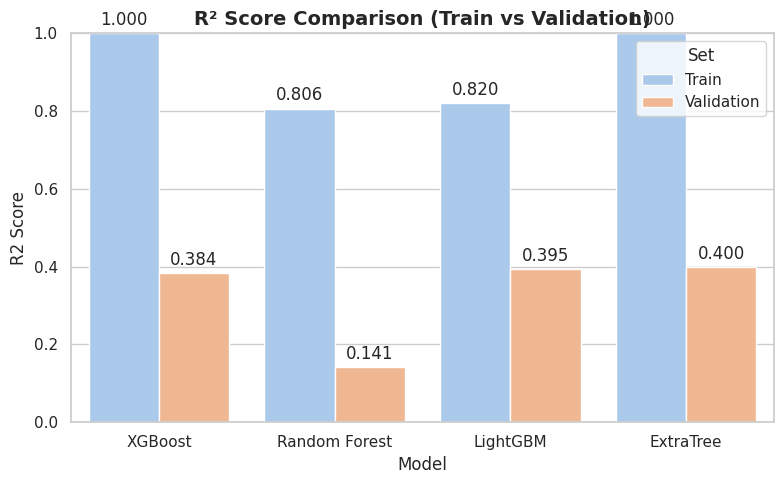

In [65]:
# 📊 Prepare model names
models = ["XGBoost", "Random Forest", "LightGBM", 'ExtraTree']

# Compute R² Scores for Training Set
r2_train = [
    r2_score(y_train, y_train_pred_xgb),
    r2_score(y_train, y_train_pred_rf),
    r2_score(y_train, y_train_pred_lgbm),
    r2_score(y_train, y_train_pred_et)
]

# Compute R² Scores for Validation Set
r2_val = [
    r2_score(y_val, y_val_pred_xgb),
    r2_score(y_val, y_val_pred_rf),
    r2_score(y_val, y_val_pred_lgbm),
    r2_score(y_val, y_val_pred_et)
]

# Create a DataFrame for plotting
df_r2 = pd.DataFrame({
    "Model": models * 2,                          
    "Set": ["Train"] * 4 + ["Validation"] * 4,  
    "R2 Score": r2_train + r2_val                 
})

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Create grouped barplot
ax = sns.barplot(data=df_r2, x="Model", y="R2 Score", hue="Set", palette="pastel")

# Add R² values on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3)

# Final formatting
plt.title("R² Score Comparison (Train vs Validation)", fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



## Conclusion
* All models have **high R² scores** on training data, indicating they fit the training data well.

* **Validation R² scores are slightly lower**, suggesting **mild overfitting**, but still very good.

* Among all, **XGBoost appears slightly more robust**, maintaining the highest validation R² score.